# Normalisation and feature analysis

In this phase, we transform the raw contract-level data into a clean, client-level profile ready for the recommendation rules.

We first standardize text fields like branche and lib_produit by removing extra spaces, converting to uppercase, and unifying synonyms (e.g., LOGEMENT(S) → HABITATION). Then, we aggregate each client’s data to compute key features: number of contracts, the set of branches and products they hold, and their total amount paid.

If available, we enrich the profile with personal details such as age, profession, or family situation. Sanity checks are applied to ensure data integrity (e.g., contract start date before end date, unique contract numbers per client/product).

Finally, the processed dataset is saved as a single client_profiles.parquet file in /outputs, ensuring that ≥99% of rows are valid and that ref_personne, branches_set, and products_set contain no missing values.

### Data Format Description
The dataset is structured in a tabular format where each row represents a single insurance contract linked to a specific client (REF_PERSONNE). Columns include both identifiers (client ID, contract number), contract details (product name, branch, start and end dates, next term date, contract status, payment status), and financial information (total premiums paid, insured capital).

Additional sheets contain client attributes such as activity sector, specific activity, or profession, which can be joined to the contracts table via REF_PERSONNE for richer profiling. The data is well-suited for transformation into a client-level aggregated file where one row corresponds to one client, combining all their contracts and profile details for analysis and recommendation generation.

#### importing libraries

In [55]:
import pandas as pd
import data_tools as datatools
import plotly.express as px

#### Loading data and overview of each sheet

In [56]:
if __name__ == "__main__":
    excel_path = "../data/Donn_es_Assurance_S2.1.xlsx" 
    # Read all sheets
    all_sheets = datatools.read_all_excel_sheets(excel_path)
    
    # Access individual sheets
    for sheet_name, df in all_sheets.items():
        print(f"\nSheet Name: {sheet_name}")
        print(f"DataFrame Shape: {df.shape}")
        print("Data quality assesment:")
        print(datatools.data_quality(df))


Sheet Name: personne_morale
DataFrame Shape: (747, 8)
Data quality assesment:
                     Data Type  Missing Values  % Missing  Unique Values
LIB_GOUVERNORAT         object             481      64.39             19
VILLE                   object             427      57.16            159
LIB_ACTIVITE            object               8       1.07            251
REF_PERSONNE            object               0       0.00            747
RAISON_SOCIALE          object               0       0.00            747
MATRICULE_FISCALE       object               0       0.00            747
LIB_SECTEUR_ACTIVITE    object               0       0.00             61
VILLE_GOUVERNORAT       object               0       0.00            167

Sheet Name: personne_physique
DataFrame Shape: (43314, 12)
Data quality assesment:
                     Data Type  Missing Values  % Missing  Unique Values
LIB_GOUVERNORAT         object           27923      64.47             24
VILLE                   object    

### We will start by cerating a centralized “Client_table” table after cleaning all string columns, so that each client (personne physique or personne morale) has all relevant information in one row, ready for analysis.

#### Sheet Name: personne_morale

In [57]:
pm=all_sheets['personne_morale']
pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   REF_PERSONNE          747 non-null    object
 1   RAISON_SOCIALE        747 non-null    object
 2   MATRICULE_FISCALE     747 non-null    object
 3   LIB_SECTEUR_ACTIVITE  747 non-null    object
 4   LIB_ACTIVITE          739 non-null    object
 5   VILLE                 320 non-null    object
 6   LIB_GOUVERNORAT       266 non-null    object
 7   VILLE_GOUVERNORAT     747 non-null    object
dtypes: object(8)
memory usage: 46.8+ KB


#### Sheet Name: personne_physique

In [58]:
pp=all_sheets['personne_physique']
pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43314 entries, 0 to 43313
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   REF_PERSONNE          43314 non-null  object
 1   NOM_PRENOM            43314 non-null  object
 2   DATE_NAISSANCE        42377 non-null  object
 3   LIEU_NAISSANCE        37661 non-null  object
 4   CODE_SEXE             43314 non-null  object
 5   SITUATION_FAMILIALE   43314 non-null  object
 6   NUM_PIECE_IDENTITE    43314 non-null  object
 7   LIB_SECTEUR_ACTIVITE  43313 non-null  object
 8   LIB_PROFESSION        40512 non-null  object
 9   VILLE                 28617 non-null  object
 10  LIB_GOUVERNORAT       15391 non-null  object
 11  VILLE_GOUVERNORAT     43314 non-null  object
dtypes: object(12)
memory usage: 4.0+ MB


#### Merging data

In [59]:
pm['TYPE_PERSONNE'] = 'MORALE'
pp['TYPE_PERSONNE'] = 'PHYSIQUE'

# Keep only relevant columns for master client table
cols_pm = ['REF_PERSONNE','RAISON_SOCIALE','MATRICULE_FISCALE','VILLE','LIB_GOUVERNORAT','LIB_SECTEUR_ACTIVITE','LIB_ACTIVITE','VILLE_GOUVERNORAT','TYPE_PERSONNE']
cols_pp = ['REF_PERSONNE','NOM_PRENOM','DATE_NAISSANCE','CODE_SEXE','SITUATION_FAMILIALE','NUM_PIECE_IDENTITE','VILLE','LIB_GOUVERNORAT','LIB_SECTEUR_ACTIVITE','LIB_PROFESSION','VILLE_GOUVERNORAT','TYPE_PERSONNE']

client_table = pd.concat([pm[cols_pm], pp[cols_pp]], ignore_index=True)


#### Checking for  duplicate values of the unique id

In [60]:
client_table['REF_PERSONNE'].duplicated().sum()

0

#### Cleaning strings and filling null values with '-'

In [61]:
client_table=datatools.clean_strings(client_table)

#### Overview of client_table data

In [62]:
datatools.data_quality(client_table)

Data Type  Missing Values  % Missing  Unique Values
REF_PERSONNE            object               0        0.0          44061
RAISON_SOCIALE          object               0        0.0            748
MATRICULE_FISCALE       object               0        0.0            748
VILLE                   object               0        0.0           2544
LIB_GOUVERNORAT         object               0        0.0             25
LIB_SECTEUR_ACTIVITE    object               0        0.0             72
LIB_ACTIVITE            object               0        0.0            251
VILLE_GOUVERNORAT       object               0        0.0           3569
TYPE_PERSONNE           object               0        0.0              2
NOM_PRENOM              object               0        0.0          43315
DATE_NAISSANCE          object               0        0.0          18385
CODE_SEXE               object               0        0.0              4
SITUATION_FAMILIALE     object               0        0.0              6
NUM_PIECE_IDENTITE      object               0        0.0          43315
LIB_PROFESSION          object               0        0.0            691

#### Extract VILLE and LIB_GOUVERNORAT from VILLE_GOUVERNORAT

In [63]:
# Split VILLE_GOUVERNORAT into two columns
split_cols = client_table['VILLE_GOUVERNORAT'].str.split('–', n=1, expand=True)

# Only assign if split works
if split_cols.shape[1] == 2:
    client_table['VILLE_from_concat'] = split_cols[0].str.strip()
    client_table['LIB_GOUVERNORAT_from_concat'] = split_cols[1].str.strip()
    
    # Optional: fill empty VILLE/LIB_GOUVERNORAT from split
    client_table['VILLE'] = client_table['VILLE'].replace('-', '')  # temporarily empty string
    client_table['VILLE'] = client_table['VILLE'].mask(client_table['VILLE'] == '', client_table['VILLE_from_concat'])
    
    client_table['LIB_GOUVERNORAT'] = client_table['LIB_GOUVERNORAT'].replace('-', '')
    client_table['LIB_GOUVERNORAT'] = client_table['LIB_GOUVERNORAT'].mask(client_table['LIB_GOUVERNORAT'] == '', client_table['LIB_GOUVERNORAT_from_concat'])
    
    # Drop helper columns
    client_table.drop(['VILLE_from_concat', 'LIB_GOUVERNORAT_from_concat'], axis=1, inplace=True)

#### Standardizing categorical fields

In [64]:
def print_unique_values(df, categorical_cols):
    """
    Prints the unique values for each categorical column in the DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze
        categorical_cols (list): List of column names to check
    """
    for col in categorical_cols:
        if col in df.columns:
            unique_vals = df[col].dropna().unique()
            print(f"\nColumn: {col}")
            print(f"Unique values ({len(unique_vals)}):")
            print(unique_vals)
        else:
            print(f"\nColumn {col} not found in DataFrame")


#### LIB_SECTEUR_ACTIVITE mapping

In [65]:
sector_map = {
    "AUCUN": "NON RENSEIGNE",
    "": "NON RENSEIGNE",
    "-": "NON RENSEIGNE",
    "INTERMÉDIATION FINANCIÈRE": "FINANCE",
    "ASSURANCE": "FINANCE",
    "AUXILIAIRES FINANCIERS ET D ASSURANCE": "FINANCE",
    "ACTIVITES IARD TARIFIABLES": "FINANCE",
    "ACTIVITES MRP TARIFIABLES": "FINANCE",
    "SERVICES PERSONNELS": "SERVICES",
    "SERVICES DOMESTIQUES": "SERVICES",
    "SERVICES FOURNIS PRINCIPALEMENT AUX ENTREPRISES": "SERVICES AUX ENTREPRISES",
    "ACTIVITÉS INFORMATIQUES": "INFORMATIQUE",
    "RECHERCHE ET DÉVELOPPEMENT": "R&D",
    "AGRICULTURE, CHASSE, SERVICES ANNEXES": "AGRICULTURE",
    "SYLVICULTURE, EXPLOITATION FORESTIÈRE, SERVICES ANNEXES": "FORESTERIE",
    "PÊCHE, AQUACULTURE": "PÊCHE",
    "TRAVAIL DU BOIS ET FABRICATION D ARTICLES EN BOIS": "BOIS",
    "INDUSTRIES ALIMENTAIRES": "AGROALIMENTAIRE",
    "INDUSTRIE CHIMIQUE": "CHIMIE",
    "INDUSTRIE DU CAOUTCHOUC ET DES PLASTIQUES": "PLASTIQUE/CAOUTCHOUC",
    "INDUSTRIE TEXTILE": "TEXTILE",
    "INDUSTRIE DE L HABILLEMENT ET DES FOURRURES": "HABILLEMENT",
    "INDUSTRIE DU CUIR ET DE LA CHAUSSURE": "CUIR",
    "FABRICATION DE MEUBLES; INDUSTRIES DIVERSES": "AMEUBLEMENT",
    "FABRICATION D AUTRES PRODUITS MINÉRAUX NON MÉTALLIQUES": "MINÉRAUX NON MÉTALLIQUES",
    "MÉTALLURGIE": "MÉTALLURGIE",
    "TRAVAIL DES MÉTAUX": "MÉTALLURGIE",
    "INDUSTRIE AUTOMOBILE": "AUTOMOBILE",
    "FABRICATION D AUTRES MATÉRIELS DE TRANSPORT": "TRANSPORT",
    "FABRICATION D ÉQUIPEMENTS DE RADIO, TÉLÉVISION ET COMMUNICATION": "ÉLECTRONIQUE",
    "FABRICATION D INSTRUMENTS MÉDICAUX, DE PRÉCISION, D OPTIQUE ET D HORLOGERIE": "INSTRUMENTS DE PRÉCISION",
    "CONSTRUCTION": "BTP",
    "COMMERCE ET RÉPARATION AUTOMOBILE": "AUTOMOBILE",
    "COMMERCE DE GROS ET INTERMÉDIAIRES DU COMMERCE": "COMMERCE",
    "COMMERCE DE DÉTAIL ET RÉPARATION D ARTICLES DOMESTIQUES": "COMMERCE",
    "STATION DE SERVICE": "COMMERCE",
    "HÔTELS ET RESTAURANTS": "HÔTELLERIE/RESTAURATION",
    "TRANSPORTS TERRESTRES": "TRANSPORT",
    "TRANSPORTS AÉRIENS": "TRANSPORT",
    "SERVICES AUXILIAIRES DES TRANSPORTS": "TRANSPORT",
    "POSTES ET TÉLÉCOMMUNICATIONS": "TÉLÉCOMMUNICATIONS",
    "ÉDUCATION": "ÉDUCATION",
    "SANTÉ ET ACTION SOCIALE": "SANTÉ",
    "ADMINISTRATION PUBLIQUE": "ADMINISTRATION PUBLIQUE",
    "ACTIVITÉS IMMOBILIÈRES": "IMMOBILIER",
    "ACTIVITÉS RÉCRÉATIVES, CULTURELLES ET SPORTIVES": "LOISIRS/SPORT",
    "ACTIVITE SPORTIVE": "LOISIRS/SPORT",
    "PRODUCTION ET DISTRIBUTION D ÉLECTRICITÉ, DE GAZ ET DE CHALEUR": "ÉNERGIE",
    "COKÉFACTION, RAFFINAGE, INDUSTRIES NUCLÉAIRES": "ÉNERGIE",
    "ASSAINISSEMENT, VOIRIE ET GESTION DES DÉCHETS": "ENVIRONNEMENT",
    "LOCATION SANS OPÉRATEUR": "LOCATION",
    "AGENCES ET BUREAUX": "SERVICES AUX ENTREPRISES",
    "ACTIVITÉS ASSOCIATIVES": "ASSOCIATIONS",
    "CADRES ET PROFESSIONS INTELLECTUELLES SUPÉRIEURES": "CADRES SUPÉRIEURS",
    "ARTISANS, COMMERÇANTS ET CHEFS D ENTREPRISE": "ENTREPRENEURS",
    "PROFESSIONS INTERMÉDIAIRES": "PROFESSIONS INTERMÉDIAIRES",
    "OUVRIERS": "OUVRIERS",
    "EMPLOYÉS": "EMPLOYÉS",
    "RETRAITÉS": "RETRAITÉS",
    "AUTRES PERSONNES SANS ACTIVITÉ PROFESSIONNELLE": "SANS ACTIVITÉ"
}

#### LIB_PROFESSION

In [66]:
profession_map = {
    # Abréviations et orthographe
    "DOC.": "DOCTEUR", "DR": "DOCTEUR", "STEWART": "HÔTESSE/STEWARD",
    "BH": "BANQUE", "OACA": "ADMINISTRATION", "STUSID": "BANQUE",
    "R&D": "RECHERCHE ET DÉVELOPPEMENT",
    
    # Regroupements thématiques
    "MÉDECIN": "SANTÉ", "INFIRMIER": "SANTÉ", "PHARMACIEN": "SANTÉ", 
    "DENTISTE": "SANTÉ", "SAGE-FEMME": "SANTÉ", "KINÉSITHÉRAPEUTE": "SANTÉ",
    "ANESTHÉSISTE": "SANTÉ", "BIOLOGISTE": "SANTÉ",
    "INGÉNIEUR": "INGÉNIEUR", "TECHNICIEN": "TECHNICIEN", 
    "PROFESSEUR": "ÉDUCATION", "ENSEIGNANT": "ÉDUCATION", "FORMATEUR": "ÉDUCATION",
    "INSTITUTEUR": "ÉDUCATION", "MAÎTRE": "ÉDUCATION",
    "COMMERCIAL": "COMMERCE", "VENDEUR": "COMMERCE", "GÉRANT": "COMMERCE",
    "COMPTABLE": "ADMINISTRATIF", "SECRÉTAIRE": "ADMINISTRATIF", 
    "ADMINISTRATEUR": "ADMINISTRATIF", "GESTIONNAIRE": "ADMINISTRATIF",
    "CADRE": "CADRE", "CHEF": "CADRE", "DIRECTEUR": "CADRE",
    "OUVRIER": "PRODUCTION", "ARTISAN": "PRODUCTION", "OPÉRATEUR": "PRODUCTION",
    "AGRICULTEUR": "AGRICULTURE", "ÉLEVEUR": "AGRICULTURE", "VITICULTEUR": "AGRICULTURE",
    "CHAUFFEUR": "TRANSPORT", "CONDUCTEUR": "TRANSPORT", "LIVREUR": "TRANSPORT",
    "AVOCAT": "JURIDIQUE", "NOTAIRE": "JURIDIQUE", "HUISSIER": "JURIDIQUE",
    "POLICIER": "SÉCURITÉ", "GENDARME": "SÉCURITÉ", "GARDIEN": "SÉCURITÉ",
    "CUISINIER": "HÔTELLERIE", "SERVEUR": "HÔTELLERIE", "RESTAURATEUR": "HÔTELLERIE",
    
    # Valeurs manquantes
    "": "NON RENSEIGNE", "-": "NON RENSEIGNE", "NON DEFINI": "NON RENSEIGNE",
    "AUCUN": "NON RENSEIGNE", "CHÔMEUR": "SANS ACTIVITÉ", 
    "RETRAITÉ": "RETRAITÉ", "ÉTUDIANT": "ÉTUDIANT"
}

#### LIB_ACTIVITE

In [67]:
activity_map = {
    "": "NON RENSEIGNE", "-": "NON RENSEIGNE", "NON DEFINI": "NON RENSEIGNE",
    "AUTRES SERVICES PERSONNELS": "SERVICES",
    "COMMERCE DE DÉTAIL": "VENTE", "COMMERCE DE GROS": "VENTE",
    "VENTE PAR CORRESPONDANCE": "VENTE", "VENTE AU DÉTAIL": "VENTE",
    "INDUSTRIES ALIMENTAIRES N.C.A.": "AGROALIMENTAIRE",
    "FABRICATION D ALIMENTS": "AGROALIMENTAIRE",
    "BOULANGERIE": "AGROALIMENTAIRE", "PÂTISSERIE": "AGROALIMENTAIRE",
    "RESTAURATION": "HÔTELLERIE/RESTAURATION",
    "HÔTELS": "HÔTELLERIE/RESTAURATION", "CAFÉS TABACS": "HÔTELLERIE/RESTAURATION",
    "CONSTRUCTION": "BTP", "MAÇONNERIE": "BTP", "TERRASSEMENT": "BTP",
    "ÉDITION, IMPRIMERIE": "MÉDIA", "TÉLÉCOMMUNICATIONS": "TÉLÉCOMMUNICATIONS",
    "RECHERCHE DÉVELOPPEMENT": "R&D", "ACTIVITÉS INFORMATIQUES": "INFORMATIQUE",
    "SANTÉ": "SANTÉ", "HÔPITAL": "SANTÉ", "CLINIQUE": "SANTÉ",
    "AGRICULTURE": "AGRICULTURE", "ÉLEVAGE": "AGRICULTURE", "PÊCHE": "PÊCHE",
    "TRANSPORT": "TRANSPORT", "MANUTENTION": "TRANSPORT",
    "ÉNERGIE": "ÉNERGIE", "EAU": "ENVIRONNEMENT", "DÉCHETS": "ENVIRONNEMENT",
    "BANQUE": "FINANCE", "ASSURANCE": "FINANCE", "CRÉDIT": "FINANCE",
    "ADMINISTRATION": "ADMINISTRATION", "DÉFENSE": "ADMINISTRATION PUBLIQUE",
    "ÉDUCATION": "ÉDUCATION", "ENSEIGNEMENT": "ÉDUCATION",
    "LOISIRS": "LOISIRS/SPORT", "SPORT": "LOISIRS/SPORT", "CULTURE": "LOISIRS/SPORT"
}

#### Mapping and checking accuracy

In [68]:
def mapping_accuracy(df, col='LIB_SECTEUR_ACTIVITE', mapping=sector_map):
    """
    Computes the percentage of values successfully mapped in a categorical column.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the column
        col (str): Column name
        mapping (dict): Dictionary used for mapping

    Returns:
        float: Mapping accuracy as a percentage
        pd.DataFrame: Unmapped values and their counts
    """
    original_values = df[col].unique()
    mapped_values = df[col].map(mapping)
    # Count how many were mapped (not NaN)
    mapped_count = mapped_values.notna().sum()
    accuracy = mapped_count / len(df[col]) * 100
    
    # Unmapped values
    unmapped = df[~df[col].isin(mapping.keys())][col].value_counts().reset_index()
    unmapped.columns = ['Unmapped Value', 'Count']
    
    return accuracy, unmapped


#### LIB_SECTEUR_ACTIVITE mapping

In [69]:
accuracy, unmapped = mapping_accuracy(client_table,col='LIB_SECTEUR_ACTIVITE',mapping=sector_map)
print(f"Mapping accuracy: {accuracy:.2f}%")
print("Unmapped values:")
print(unmapped)

Mapping accuracy: 54.29%
Unmapped values:
                                       Unmapped Value  Count
0                                 STATION  DE SERVICE  13677
1                                          COMMERCIAL   5352
2                                           INDUSTRIE    916
3                                           INGENIEUR    158
4                       AUTRES INDUSTRIES EXTRACTIVES      7
5                    INDUSTRIE DU PAPIER ET DU CARTON      5
6              FABRICATION DE MACHINES ET ÉQUIPEMENTS      5
7                  EXTRACTION DE MINERAIS MÉTALLIQUES      5
8                   ÉDITION, IMPRIMERIE, REPRODUCTION      4
9   FABRICATION DE MACHINES DE BUREAU ET DE MATÉRI...      3
10   FABRICATION DE MACHINES ET APPAREILS ÉLECTRIQUES      3
11    EXTRACTION DE HOUILLE, DE LIGNITE ET DE TOURBES      2
12                 INDUSTRIE DES PRODUITS ARTISANALES      2


#### LIB_PROFESSION mapping

In [70]:
accuracy, unmapped = mapping_accuracy(client_table,col='LIB_PROFESSION',mapping=profession_map)
print(f"Mapping accuracy: {accuracy:.2f}%")
print("Unmapped values:")
print(unmapped)

Mapping accuracy: 33.59%
Unmapped values:
                                        Unmapped Value  Count
0                                           NON FOURNI   4743
1                                          NON DEFINIE   2708
2                                               GERANT   2311
3                                             RETRAITE   2267
4                                            MILITAIRE    917
..                                                 ...    ...
661          DESSINATEURS EN BÂTIMENT, TRAVAUX PUBLICS      1
662                            INDUSTRIE METALLURGIQUE      1
663  CHAUFFAGE (COMMERCE D APPAREILS), SANS POSE NI...      1
664  BIBLIOTHÉCAIRES, ARCHIVISTES, CONSERVATEURS ET...      1
665  ARTISANS DE FABRICATION EN MATÉRIAUX DE CONSTR...      1

[666 rows x 2 columns]


#### LIB_ACTIVITE mapping

In [71]:
accuracy, unmapped = mapping_accuracy(client_table,col='LIB_ACTIVITE',mapping=activity_map)
print(f"Mapping accuracy: {accuracy:.2f}%")
print("Unmapped values:")
print(unmapped)

Mapping accuracy: 98.57%
Unmapped values:
                                        Unmapped Value  Count
0                   PROMOTION IMMOBILIÈRE DE LOGEMENTS     24
1                              AUXILIAIRES D ASSURANCE     16
2              CONSEIL POUR LES AFFAIRES ET LA GESTION     12
3                                   AGENCES ET BUREAUX     12
4                                              BANQUES     12
..                                                 ...    ...
237                 LINGE DE MAISON (MAGASIN DE VENTE)      1
238     VENTE PAR CORRESPONDANCE SUR CATALOGUE GÉNÉRAL      1
239            ACTIVITÉS GÉNÉRALES DE SÉCURITÉ SOCIALE      1
240                COMMERCE DE DÉTAIL DE QUINCAILLERIE      1
241  FABRICATION D ÉLÉMENTS EN MATIÈRES PLASTIQUES ...      1

[242 rows x 2 columns]


#### Exporting client_table

In [72]:
client_table.to_csv('../outputs/client_table.csv')

#### Distribution of client types (morale vs physique)

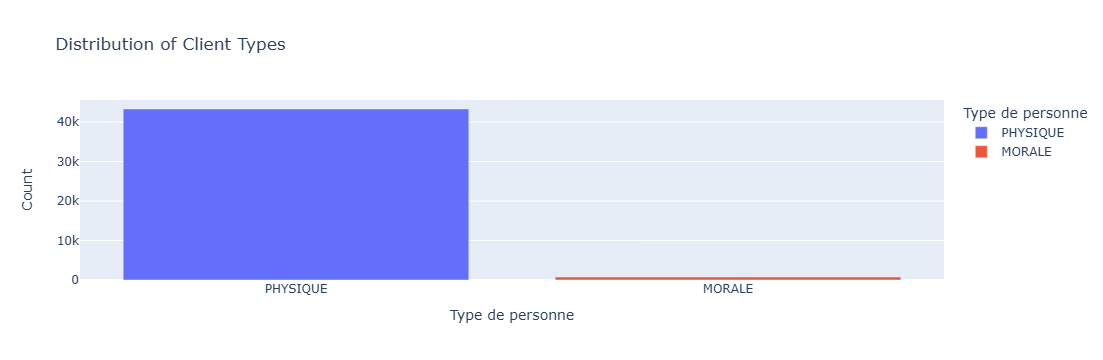

In [73]:
client_type_counts = client_table["TYPE_PERSONNE"].value_counts().reset_index()
client_type_counts.columns = ["TYPE_PERSONNE", "count"]
fig = px.bar(
    client_type_counts,
    x="TYPE_PERSONNE", y="count",
    labels={"TYPE_PERSONNE": "Type de personne", "count": "Count"},
    title="Distribution of Client Types",color="TYPE_PERSONNE"
)
fig.show()

#### Sectors for companies (LIB_SECTEUR_ACTIVITE)

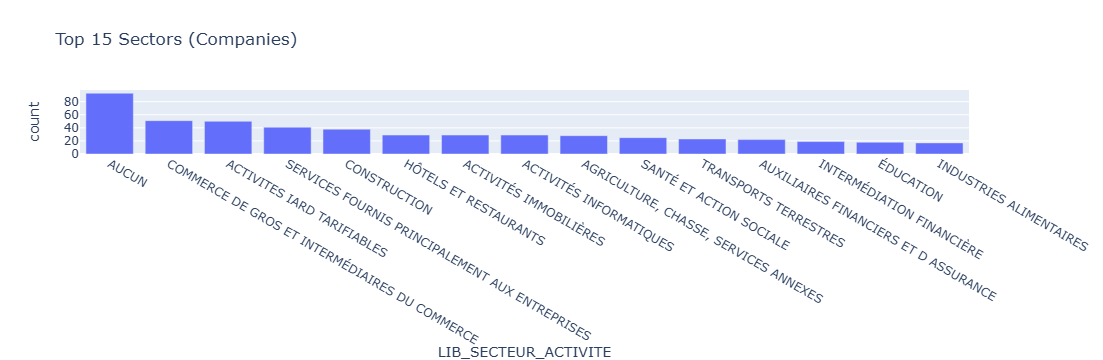

In [74]:
morale_sectors = (
client_table[client_table["TYPE_PERSONNE"]=="MORALE"]["LIB_SECTEUR_ACTIVITE"]
    .value_counts().head(15).reset_index()
)
morale_sectors.columns = ["LIB_SECTEUR_ACTIVITE", "count"]

fig = px.bar(
    morale_sectors,
    x="LIB_SECTEUR_ACTIVITE", y="count",
    title="Top 15 Sectors (Companies)"
)
fig.show()

#### Professions for individuals (LIB_PROFESSION)


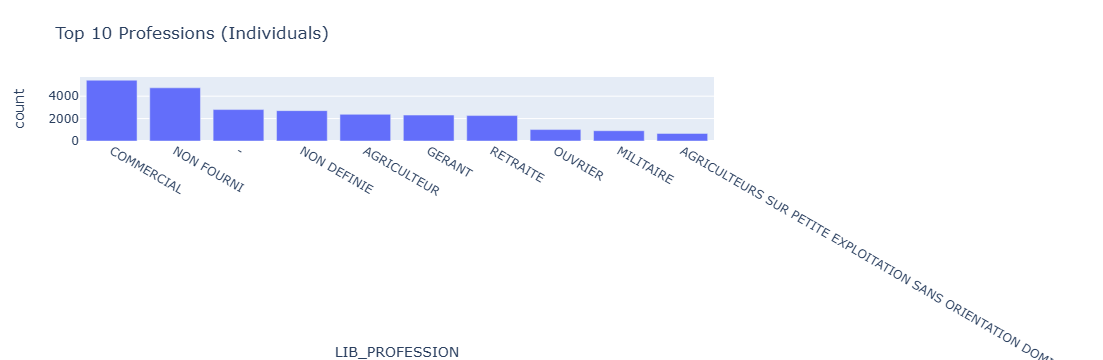

In [75]:
physique_profs = (
    client_table[client_table["TYPE_PERSONNE"]=="PHYSIQUE"]["LIB_PROFESSION"]
    .value_counts().head(10).reset_index()
)
physique_profs.columns = ["LIB_PROFESSION", "count"]

fig = px.bar(
    physique_profs,
    x="LIB_PROFESSION", y="count",
    title="Top 10 Professions (Individuals)"
)
fig.show()

#### Geographic distribution (Governorate)


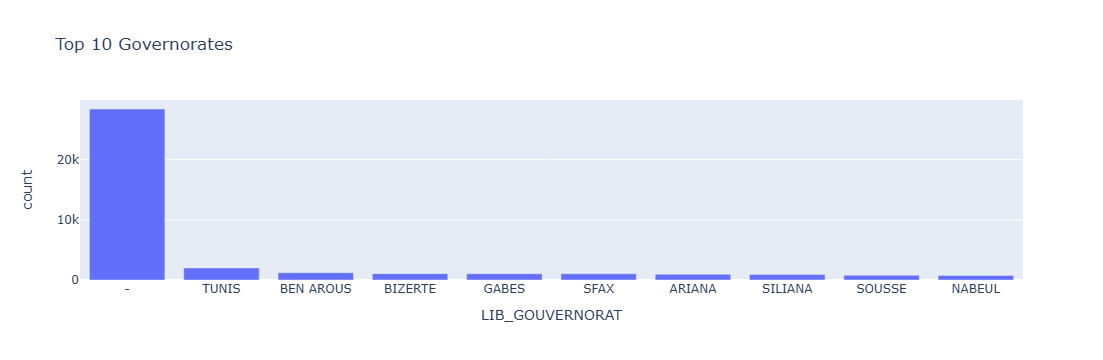

In [76]:
gov_counts = client_table["LIB_GOUVERNORAT"].value_counts().head(10).reset_index()
gov_counts.columns = ["LIB_GOUVERNORAT", "count"]

fig = px.bar(
    gov_counts,
    x="LIB_GOUVERNORAT", y="count",
    title="Top 10 Governorates"
)
fig.show()

#### Age distribution

C:\Users\dhiea.DHIA\AppData\Local\Temp\ipykernel_15752\2044614400.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



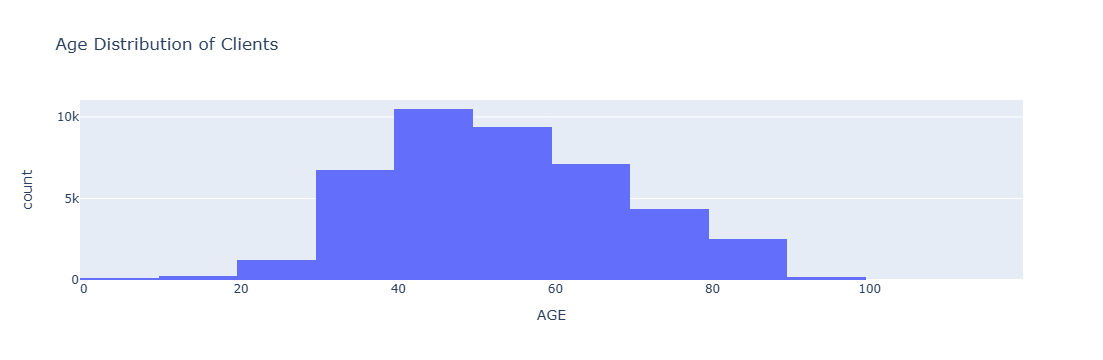

In [77]:
from datetime import datetime
client_table["AGE"] = (
    (datetime.now() - pd.to_datetime(client_table["DATE_NAISSANCE"], errors="coerce")).dt.days // 365
)

fig = px.histogram(
    client_table, x="AGE", nbins=20,
    title="Age Distribution of Clients"
)
fig.show()

#### Family situation

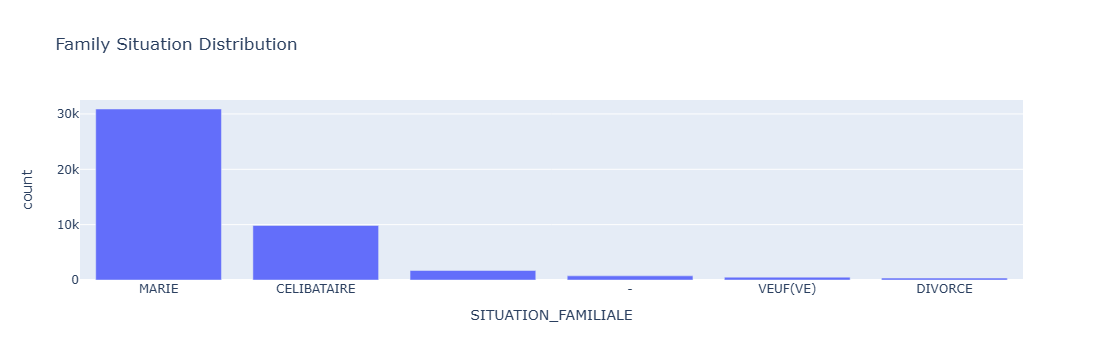

In [78]:
fam_counts = client_table["SITUATION_FAMILIALE"].value_counts().reset_index()
fam_counts.columns = ["SITUATION_FAMILIALE", "count"]

fig = px.bar(
    fam_counts,
    x="SITUATION_FAMILIALE", y="count",
    title="Family Situation Distribution"
)
fig.show()

#### Age by family situation

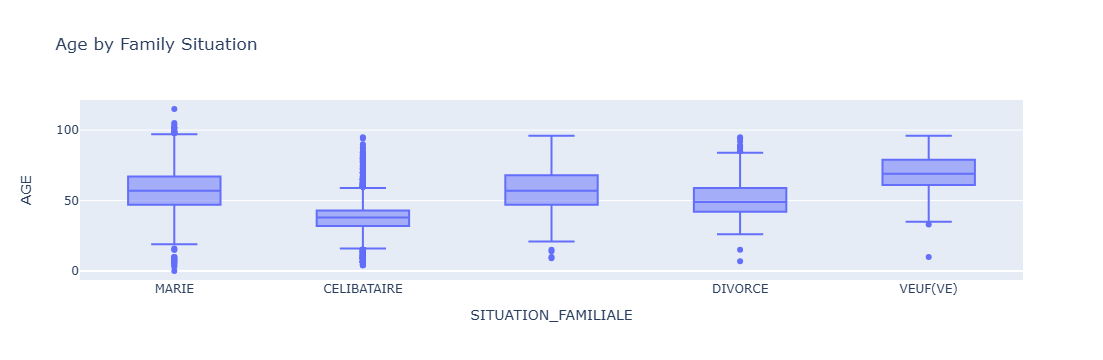

In [79]:
fig = px.box(client_table, x="SITUATION_FAMILIALE", y="AGE", title="Age by Family Situation")
fig.show()

#### Sector activity by governorate (heatmap-like)

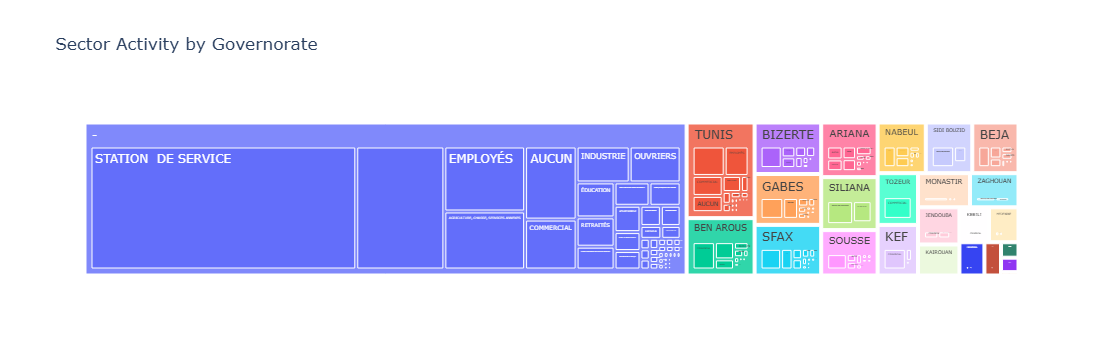

In [80]:
sector_gov = client_table.groupby(["LIB_GOUVERNORAT", "LIB_SECTEUR_ACTIVITE"]).size().reset_index(name="count")
fig = px.treemap(sector_gov, path=["LIB_GOUVERNORAT","LIB_SECTEUR_ACTIVITE"], values="count", title="Sector Activity by Governorate")
fig.show()

#### Exploratory sanity check

In [81]:
print(client_table["TYPE_PERSONNE"].value_counts())
print(client_table["LIB_SECTEUR_ACTIVITE"].value_counts().head(10))
print(client_table["AGE"].describe())
print(client_table["LIB_GOUVERNORAT"].value_counts().head(10))


TYPE_PERSONNE
PHYSIQUE    43314
MORALE        747
Name: count, dtype: int64
LIB_SECTEUR_ACTIVITE
STATION  DE SERVICE                      13677
                                          7617
COMMERCIAL                                5352
AGRICULTURE, CHASSE, SERVICES ANNEXES     4133
EMPLOYÉS                                  3431
AUCUN                                     2803
OUVRIERS                                   961
INDUSTRIE                                  916
ÉDUCATION                                  817
RETRAITÉS                                  731
Name: count, dtype: int64
count    42373.000000
mean        53.300286
std         15.474257
min          0.000000
25%         42.000000
50%         52.000000
75%         64.000000
max        115.000000
Name: AGE, dtype: float64
LIB_GOUVERNORAT
-            28404
TUNIS         2005
BEN AROUS     1202
BIZERTE       1058
GABES         1045
SFAX          1040
ARIANA         950
SILIANA        921
SOUSSE         789
NABEUL         753

In [82]:
client_table[client_table['AGE']==client_table['AGE'].min()]

REF_PERSONNE RAISON_SOCIALE MATRICULE_FISCALE        VILLE  \
3839       104452              -                 -  EL MENZAH 6   

     LIB_GOUVERNORAT LIB_SECTEUR_ACTIVITE LIB_ACTIVITE     VILLE_GOUVERNORAT  \
3839          ARIANA           COMMERCIAL            -  EL MENZAH 6 - ARIANA   

     TYPE_PERSONNE      NOM_PRENOM           DATE_NAISSANCE CODE_SEXE  \
3839      PHYSIQUE  PERSONNE_03093  2025-07-02 00:00:00.000         M   

     SITUATION_FAMILIALE NUM_PIECE_IDENTITE LIB_PROFESSION  AGE  
3839               MARIE           10003093     COMMERCIAL  0.0

### After building the unified client profile in Step 1, the next step is to enrich these profiles with contractual information. By merging the Contrats dataset with the client_table, we can capture each client’s insurance behavior, including the number of contracts they hold, the types of branches and products they subscribe to, the total premiums paid, and the status of their contracts (active, terminated, suspended). This transformation turns static demographic data into dynamic behavioral profiles, forming the basis for deeper customer segmentation and recommendation strategies.

#### Merging data

In [83]:
contracts = all_sheets['Contrats']

# Clean strings for consistency
contracts = datatools.clean_strings(contracts)

# Merge contracts with client_table
client_contracts = contracts.merge(
    client_table[['REF_PERSONNE', 'TYPE_PERSONNE']],
    on="REF_PERSONNE",
    how="left"
)


#### Aggregating contract-level features per client

#### Step-by-step explanation:

groupby("REF_PERSONNE")
→ Groups all rows of the client_contracts dataset by client ID (REF_PERSONNE), so that each client has their contracts aggregated together.

contracts_count=("NUM_CONTRAT", "nunique")
→ For each client, count the number of unique contracts they have.

branches_set=("branche", lambda x: list(set(x)))
→ Collects all distinct insurance branches a client subscribed to and stores them as a Python list (no duplicates).

products_set=("LIB_PRODUIT", lambda x: list(set(x)))
→ Same as above, but for distinct products subscribed.

total_paid=("somme_quittances", "sum")
→ Sums all the premiums paid (somme_quittances) for that client.

active_contracts=("LIB_ETAT_CONTRAT", lambda x: sum(x=="ACTIF"))
→ Counts how many contracts are currently active.

terminated_contracts=("LIB_ETAT_CONTRAT", lambda x: sum(x=="RESILIE"))
→ Counts how many contracts are terminated.

suspended_contracts=("LIB_ETAT_CONTRAT", lambda x: sum(x=="SUSPENDU"))
→ Counts how many contracts are suspended.

.reset_index()
→ Converts the grouped result back into a normal DataFrame with one row per client.

In [84]:
agg_contracts = client_contracts.groupby("REF_PERSONNE").agg(
    contracts_count=("NUM_CONTRAT", "nunique"),
    branches_set=("branche", lambda x: list(set(x))),
    products_set=("LIB_PRODUIT", lambda x: list(set(x))),
    total_paid=("somme_quittances", "sum"),
    active_contracts=("LIB_ETAT_CONTRAT", lambda x: sum(x=="EN COURS")),
    expired_contracts=("LIB_ETAT_CONTRAT", lambda x: sum(x=="EXPIRE")),
    reduced_contracts=("LIB_ETAT_CONTRAT", lambda x: sum(x=="REDUIT")),
    instance_contracts=("LIB_ETAT_CONTRAT", lambda x: sum(x=="EN INSTANCE/DEVIS")),
    terminated_contracts=("LIB_ETAT_CONTRAT", lambda x: sum(x=="RESILIE")),
    suspended_contracts=("LIB_ETAT_CONTRAT", lambda x: sum(x=="SUSPENDU"))
).reset_index()

In [85]:
agg_contracts.head()

REF_PERSONNE  contracts_count  branches_set  products_set  \
0       100052                1  [AUTOMOBILE]  [AUTOMOBILE]   
1       100097                1  [AUTOMOBILE]  [AUTOMOBILE]   
2       100187                3  [AUTOMOBILE]  [AUTOMOBILE]   
3       100213                1  [AUTOMOBILE]  [AUTOMOBILE]   
4       100214                2  [AUTOMOBILE]  [AUTOMOBILE]   

             total_paid  active_contracts  expired_contracts  \
0              6100.502                 1                  0   
1                 893.4                 0                  0   
2  318.99817.3041356.41                 0                  1   
3                 410.4                 0                  1   
4           299.6642.85                 0                  1   

   reduced_contracts  instance_contracts  terminated_contracts  \
0                  0                   0                     0   
1                  0                   0                     1   
2                  0                   0                     2   
3                  0                   0                     0   
4                  0                   0                     1   

   suspended_contracts  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

#### 1. Distribution of contracts per client

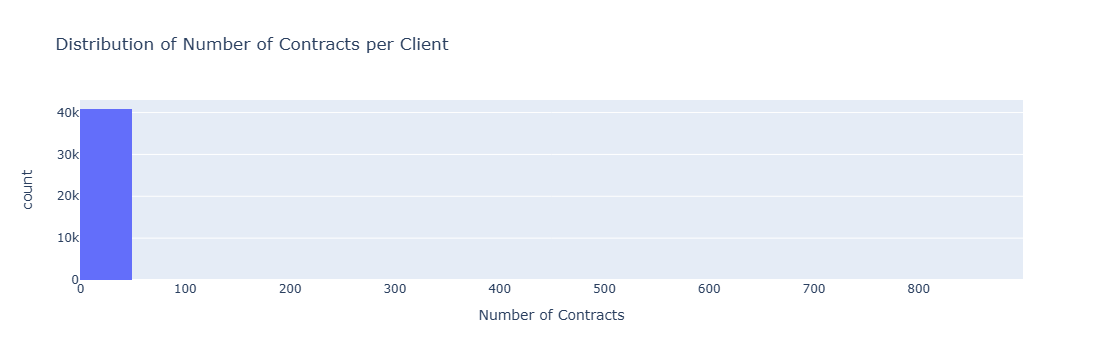

In [86]:
fig1 = px.histogram(
    agg_contracts,
    x="contracts_count",
    nbins=20,
    title="Distribution of Number of Contracts per Client",
    labels={"contracts_count": "Number of Contracts"}
)
fig1.show()

#### 2. Total premiums paid per client (skewed → log scale)

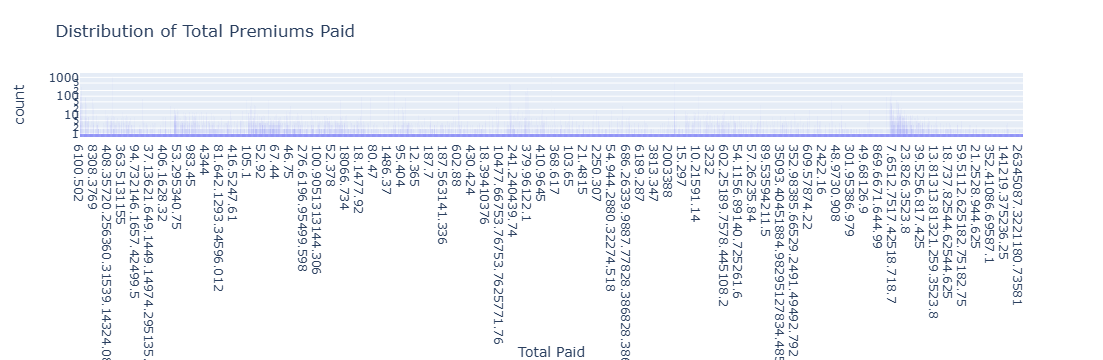

In [87]:
fig2 = px.histogram(
    agg_contracts,
    x="total_paid",
    nbins=50,
    title="Distribution of Total Premiums Paid",
    labels={"total_paid": "Total Paid"},
    log_y=True
)
fig2.show()

#### 3. Active vs Resiliated vs Suspended contracts (global sums)

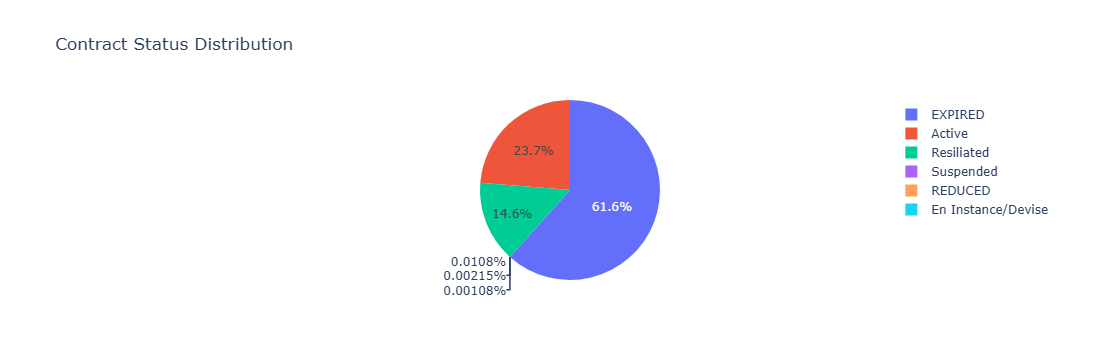

In [88]:
status_summary = {
    "Active": agg_contracts["active_contracts"].sum(),
    "EXPIRED": agg_contracts["expired_contracts"].sum(),
    "REDUCED": agg_contracts["reduced_contracts"].sum(),
    "En Instance/Devise": agg_contracts["instance_contracts"].sum(),
    "Resiliated": agg_contracts["terminated_contracts"].sum(),
    "Suspended": agg_contracts["suspended_contracts"].sum()
}
fig3 = px.pie(
    names=list(status_summary.keys()),
    values=list(status_summary.values()),
    title="Contract Status Distribution"
)
fig3.show()

#### 4. Top branches subscribed (flatten list of branches)

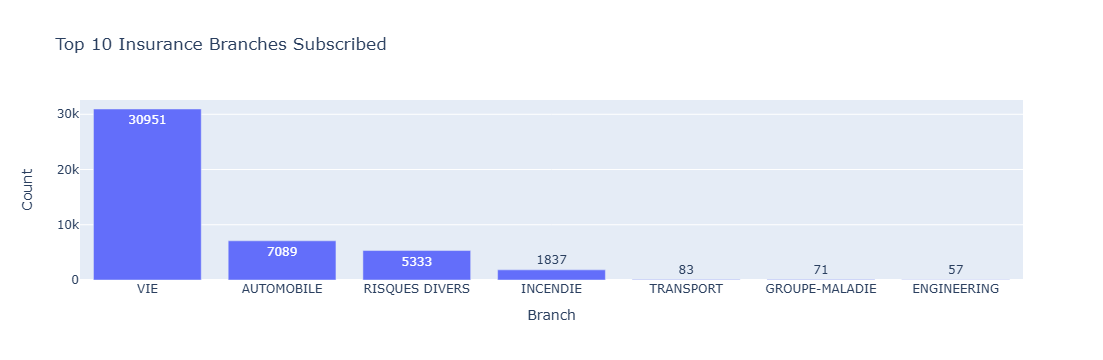

In [89]:
import itertools
all_branches = list(itertools.chain.from_iterable(agg_contracts["branches_set"]))
branch_counts = pd.Series(all_branches).value_counts().reset_index()
branch_counts.columns = ["Branch", "Count"]

fig4 = px.bar(
    branch_counts.head(10),
    x="Branch", y="Count",
    title="Top 10 Insurance Branches Subscribed",
    text="Count"
)
fig4.show()

#### 5. Top products subscribed (flatten list of products)

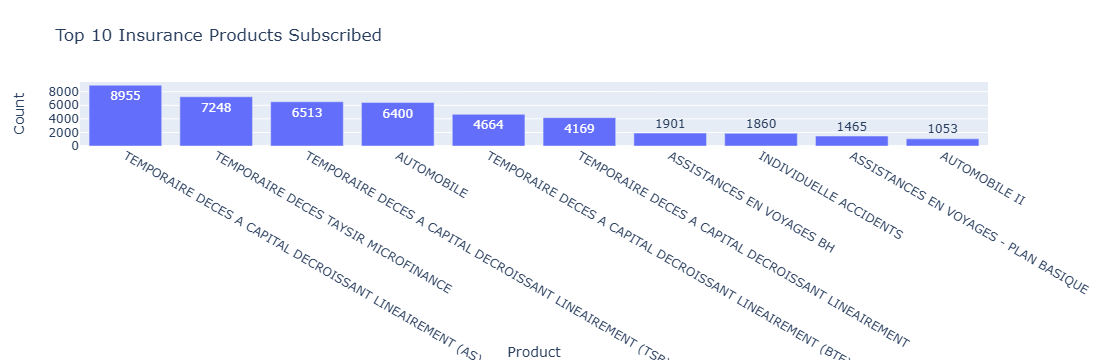

In [90]:
all_products = list(itertools.chain.from_iterable(agg_contracts["products_set"]))
product_counts = pd.Series(all_products).value_counts().reset_index()
product_counts.columns = ["Product", "Count"]

fig5 = px.bar(
    product_counts.head(10),
    x="Product", y="Count",
    title="Top 10 Insurance Products Subscribed",
    text="Count"
)
fig5.show()


#### Merging back into client_table

In [91]:
client_table = client_table.merge(agg_contracts, on="REF_PERSONNE", how="left")

# Fill NaN for clients with no contracts
client_table[["contracts_count","total_paid","active_contracts",
              "terminated_contracts","suspended_contracts"]] = client_table[
    ["contracts_count","total_paid","active_contracts",
     "terminated_contracts","suspended_contracts"]
].fillna(0)


#### Analysing claims data

In [92]:
client_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44061 entries, 0 to 44060
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   REF_PERSONNE          44061 non-null  object 
 1   RAISON_SOCIALE        44061 non-null  object 
 2   MATRICULE_FISCALE     44061 non-null  object 
 3   VILLE                 44061 non-null  object 
 4   LIB_GOUVERNORAT       44061 non-null  object 
 5   LIB_SECTEUR_ACTIVITE  44061 non-null  object 
 6   LIB_ACTIVITE          44061 non-null  object 
 7   VILLE_GOUVERNORAT     44061 non-null  object 
 8   TYPE_PERSONNE         44061 non-null  object 
 9   NOM_PRENOM            44061 non-null  object 
 10  DATE_NAISSANCE        44061 non-null  object 
 11  CODE_SEXE             44061 non-null  object 
 12  SITUATION_FAMILIALE   44061 non-null  object 
 13  NUM_PIECE_IDENTITE    44061 non-null  object 
 14  LIB_PROFESSION        44061 non-null  object 
 15  AGE                

In [93]:
claims=all_sheets['sinistres']
print(datatools.data_quality(claims))

                     Data Type  Missing Values  % Missing  Unique Values
MOTIF_REOUVERTURE       object           10842      97.24             83
OBSERVATION_SINISTRE    object            8940      80.18           1698
LIEU_ACCIDENT           object            4794      43.00           2457
TAUX_RESPONSABILITE     object            1801      16.15              8
LIB_TYPE_SINISTRE       object             566       5.08             20
NUM_SINISTRE            object               0       0.00          11150
DATE_OUVERTURE          object               0       0.00           4024
MONTANT_ENCAISSE        object               0       0.00           7482
LIB_ETAT_SINISTRE       object               0       0.00              5
DATE_SURVENANCE         object               0       0.00           5072
DATE_DECLARATION        object               0       0.00           4300
NUM_CONTRAT             object               0       0.00           5033
NATURE_SINISTRE         object               0     

#### Converting numeric columns

In [94]:
claims['MONTANT_ENCAISSE'] = pd.to_numeric(claims['MONTANT_ENCAISSE'], errors='coerce')
claims['MONTANT_A_ENCAISSER'] = pd.to_numeric(claims['MONTANT_A_ENCAISSER'], errors='coerce')

#### Converting date columns

In [95]:
date_cols = ['DATE_OUVERTURE', 'DATE_SURVENANCE', 'DATE_DECLARATION']
for col in date_cols:
    claims[col] = pd.to_datetime(claims[col], errors='coerce')

#### handling the missing categorical values and droping nearly-empty columns in claims dataset

In [96]:
# Fill missing categorical values
claims['TAUX_RESPONSABILITE'] = claims['TAUX_RESPONSABILITE'].fillna('UNKNOWN')
claims['LIEU_ACCIDENT'] = claims['LIEU_ACCIDENT'].fillna('UNKNOWN')

# Drop nearly-empty columns
claims = claims.drop(columns=['MOTIF_REOUVERTURE'])

# check result
print(claims[['TAUX_RESPONSABILITE', 'LIEU_ACCIDENT']].isna().sum())
print(claims.head())


TAUX_RESPONSABILITE    0
LIEU_ACCIDENT          0
dtype: int64
  NUM_SINISTRE    NUM_CONTRAT LIB_BRANCHE LIB_SOUS_BRANCHE LIB_PRODUIT  \
0  20033000932  2001300001063  AUTOMOBILE       AUTOMOBILE  AUTOMOBILE   
1  20043000048  2002300001183  AUTOMOBILE       AUTOMOBILE  AUTOMOBILE   
2  20043000564  2003300002468  AUTOMOBILE       AUTOMOBILE  AUTOMOBILE   
3  20043000882  2003300000453  AUTOMOBILE       AUTOMOBILE  AUTOMOBILE   
4  20043000915  2003300001137  AUTOMOBILE       AUTOMOBILE  AUTOMOBILE   

  NATURE_SINISTRE LIB_TYPE_SINISTRE TAUX_RESPONSABILITE DATE_SURVENANCE  \
0        MATERIEL       DEFENSE IDA                 100      2003-10-28   
1        MATERIEL       RECOURS IDA                   0      2004-01-06   
2        MATERIEL       RECOURS IDA                   0      2004-05-19   
3        MATERIEL        FACULTATIF                 100      2004-09-07   
4        MATERIEL        FACULTATIF                 100      2004-09-25   

  DATE_DECLARATION DATE_OUVERTURE   OBSER

In [97]:
claims_by_branch = claims.pivot_table(
    index='NUM_CONTRAT',
    columns='LIB_BRANCHE',
    values='NUM_SINISTRE',
    aggfunc='count',
    fill_value=0
)


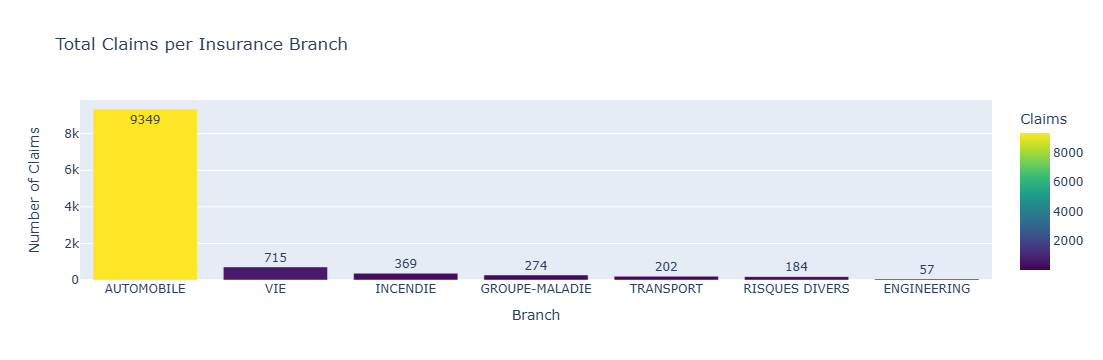

In [98]:

# Sum across all clients to get total claims per branch
total_claims_per_branch = claims_by_branch.sum().sort_values(ascending=False).reset_index()
total_claims_per_branch.columns = ['Branch', 'Claims']

# Plot
fig = px.bar(
    total_claims_per_branch,
    x='Branch',
    y='Claims',
    title='Total Claims per Insurance Branch',
    text='Claims',
    color='Claims',
    color_continuous_scale='Viridis'
)
fig.update_layout(xaxis_title='Branch', yaxis_title='Number of Claims')
fig.show()

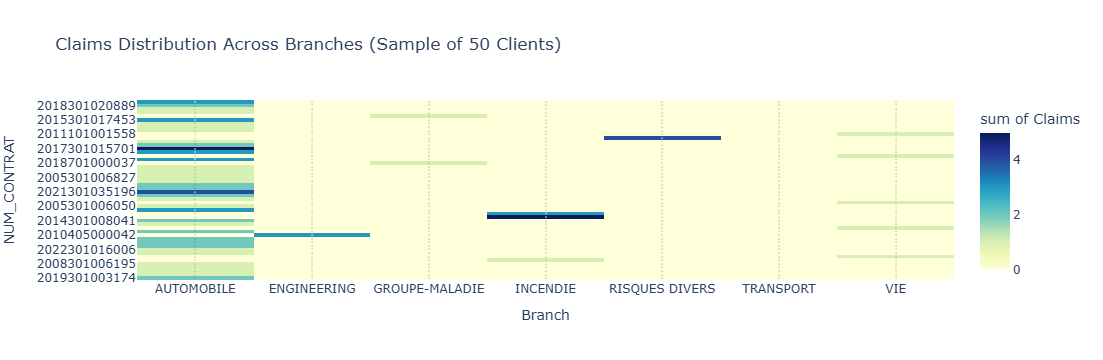

In [99]:

# Sample 50 clients for clarity
sample_claims = claims_by_branch.sample(50).reset_index()
sample_claims_melted = sample_claims.melt(id_vars='NUM_CONTRAT', var_name='Branch', value_name='Claims')

# Plot
fig = px.density_heatmap(
    sample_claims_melted,
    x='Branch',
    y='NUM_CONTRAT',
    z='Claims',
    text_auto=True,
    title='Claims Distribution Across Branches (Sample of 50 Clients)',
    color_continuous_scale='YlGnBu'
)
fig.show()

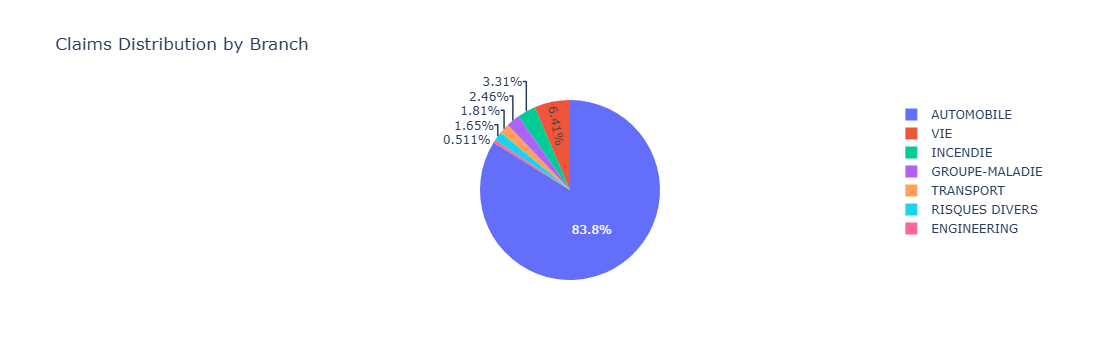

In [100]:
fig = px.pie(
    total_claims_per_branch,
    names='Branch',
    values='Claims',
    title='Claims Distribution by Branch'
)
fig.show()

In [101]:
recent_threshold = pd.Timestamp('2025-01-01')  # Adjust as needed
recent_claims = claims.groupby('NUM_CONTRAT')['DATE_SURVENANCE'].max()
has_recent_claim = ((recent_claims >= recent_threshold).astype(int).rename('has_recent_claim')).value_counts().reset_index()


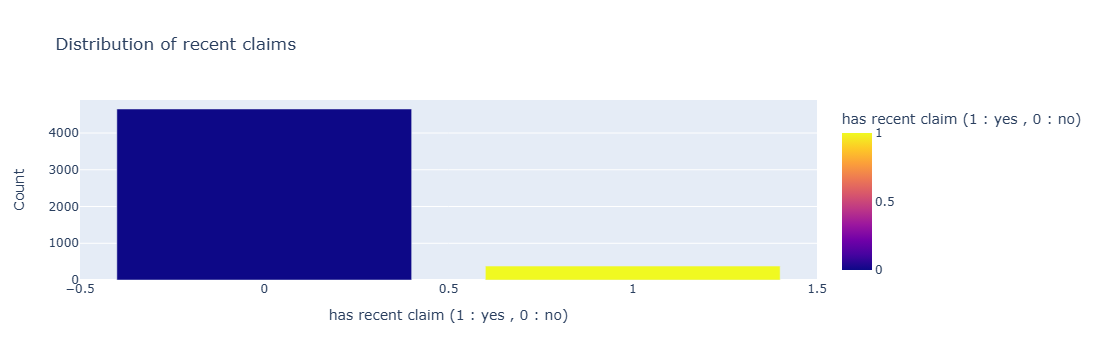

In [102]:
fig = px.bar(
    has_recent_claim,
    x="has_recent_claim", y="count",
    labels={"has_recent_claim": "has recent claim (1 : yes , 0 : no)", "count": "Count"},
    title="Distribution of recent claims",color="has_recent_claim"
)
fig.show()

### Now we have : 
#### Client-level dataframe (client_table) with one row per REF_PERSONNE and contract summary features.
#### Claims dataframe (claims) with one row per claim (NUM_SINISTRE) linked to contracts (NUM_CONTRAT)


#### Linking claims to clients via contracts

#### claims has NUM_CONTRAT.

#### client_table has aggregated contract info but also has REF_PERSONNE.

#### we need a mapping from contract → client.

#### We will first ensure claims have client reference

#### claims has NUM_CONTRAT but no REF_PERSONNE, we need a contract-to-client mapping.

#### Since our client table doesn’t have NUM_CONTRAT, we already have a contracts dataframe that links NUM_CONTRAT → REF_PERSONNE.

In [103]:
# Merge claims with contracts to get REF_PERSONNE
claims = claims.merge(
    contracts[['NUM_CONTRAT', 'REF_PERSONNE']],
    on='NUM_CONTRAT',
    how='left'
)

#### Total claims per client

In [104]:
claims_count = claims.groupby('REF_PERSONNE').size().rename('claims_count')

In [105]:
# Make sure claims has REF_PERSONNE
# Pivot table to get claims per branch per client
claims_by_branch = claims.pivot_table(
    index='REF_PERSONNE',      # use client ID instead of contract
    columns='LIB_BRANCHE',
    values='NUM_SINISTRE',
    aggfunc='count',
    fill_value=0
).reset_index()  # make REF_PERSONNE a column for merging

#### Has recent claim (binary) (per client)

In [106]:
recent_threshold = pd.Timestamp('2024-01-01')
has_recent_claim = claims.groupby('REF_PERSONNE')['DATE_SURVENANCE'].max()
has_recent_claim = (has_recent_claim >= recent_threshold).astype(int).rename('has_recent_claim')

In [107]:
claims.head()

NUM_SINISTRE    NUM_CONTRAT LIB_BRANCHE LIB_SOUS_BRANCHE LIB_PRODUIT  \
0  20033000932  2001300001063  AUTOMOBILE       AUTOMOBILE  AUTOMOBILE   
1  20043000048  2002300001183  AUTOMOBILE       AUTOMOBILE  AUTOMOBILE   
2  20043000564  2003300002468  AUTOMOBILE       AUTOMOBILE  AUTOMOBILE   
3  20043000882  2003300000453  AUTOMOBILE       AUTOMOBILE  AUTOMOBILE   
4  20043000915  2003300001137  AUTOMOBILE       AUTOMOBILE  AUTOMOBILE   

  NATURE_SINISTRE LIB_TYPE_SINISTRE TAUX_RESPONSABILITE DATE_SURVENANCE  \
0        MATERIEL       DEFENSE IDA                 100      2003-10-28   
1        MATERIEL       RECOURS IDA                   0      2004-01-06   
2        MATERIEL       RECOURS IDA                   0      2004-05-19   
3        MATERIEL        FACULTATIF                 100      2004-09-07   
4        MATERIEL        FACULTATIF                 100      2004-09-25   

  DATE_DECLARATION DATE_OUVERTURE   OBSERVATION_SINISTRE LIB_ETAT_SINISTRE  \
0       2003-11-21     2003-12-09                    NaN           CLOTURE   
1       2004-01-14     2004-01-14                    NaN           CLOTURE   
2       2004-06-15     2004-06-15                    NaN           CLOTURE   
3       2004-09-08     2004-09-08  EXCLUE DE LA GARANTIE           CLOTURE   
4       2004-09-27     2004-09-27                    NaN           CLOTURE   

  LIEU_ACCIDENT  MONTANT_ENCAISSE  MONTANT_A_ENCAISSER REF_PERSONNE  
0       UNKNOWN               0.0             1951.687         1183  
1       UNKNOWN               0.0              200.240       133457  
2       UNKNOWN               0.0              299.903        47734  
3       UNKNOWN               0.0               33.230         6369  
4       UNKNOWN               0.0               68.679       122687

#### Merging aggregated claims into client table

In [108]:
# Merge into client_table
client_table = client_table.merge(claims_count, on='REF_PERSONNE', how='left')
client_table = client_table.merge(claims_by_branch, on='REF_PERSONNE', how='left')
client_table = client_table.merge(has_recent_claim, on='REF_PERSONNE', how='left')

# Fill NaNs for clients with no claims
client_table['claims_count'] = client_table['claims_count'].fillna(0)
client_table['has_recent_claim'] = client_table['has_recent_claim'].fillna(0)

In [109]:
client_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44061 entries, 0 to 44060
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   REF_PERSONNE          44061 non-null  object 
 1   RAISON_SOCIALE        44061 non-null  object 
 2   MATRICULE_FISCALE     44061 non-null  object 
 3   VILLE                 44061 non-null  object 
 4   LIB_GOUVERNORAT       44061 non-null  object 
 5   LIB_SECTEUR_ACTIVITE  44061 non-null  object 
 6   LIB_ACTIVITE          44061 non-null  object 
 7   VILLE_GOUVERNORAT     44061 non-null  object 
 8   TYPE_PERSONNE         44061 non-null  object 
 9   NOM_PRENOM            44061 non-null  object 
 10  DATE_NAISSANCE        44061 non-null  object 
 11  CODE_SEXE             44061 non-null  object 
 12  SITUATION_FAMILIALE   44061 non-null  object 
 13  NUM_PIECE_IDENTITE    44061 non-null  object 
 14  LIB_PROFESSION        44061 non-null  object 
 15  AGE                

In [110]:
branch_columns = ['AUTOMOBILE', 'ENGINEERING', 'GROUPE-MALADIE', 
                  'INCENDIE', 'RISQUES DIVERS', 'TRANSPORT', 'VIE']
client_table[branch_columns] = client_table[branch_columns].fillna(0)
print(client_table[['claims_count', 'has_recent_claim'] + branch_columns].head(15))


    claims_count  has_recent_claim  AUTOMOBILE  ENGINEERING  GROUPE-MALADIE  \
0            1.0               0.0         1.0          0.0             0.0   
1            0.0               0.0         0.0          0.0             0.0   
2            6.0               0.0         6.0          0.0             0.0   
3            4.0               0.0         4.0          0.0             0.0   
4            2.0               0.0         2.0          0.0             0.0   
5            0.0               0.0         0.0          0.0             0.0   
6            4.0               0.0         4.0          0.0             0.0   
7            2.0               0.0         2.0          0.0             0.0   
8            8.0               0.0         8.0          0.0             0.0   
9            0.0               0.0         0.0          0.0             0.0   
10           1.0               0.0         1.0          0.0             0.0   
11           6.0               1.0         6.0      

### Exploratory Analysis

#### Top Branches / Products Subscribed

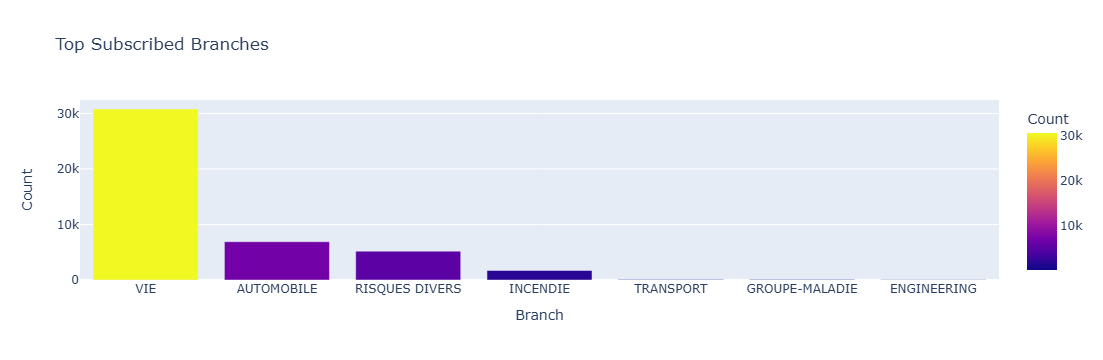

In [111]:
# Replace NaN with empty lists
client_table['branches_set'] = client_table['branches_set'].apply(lambda x: x if isinstance(x, list) else [])

# Flatten the lists to get one row per branch
branch_counts = client_table['branches_set'].explode().value_counts().reset_index()
branch_counts.columns = ['Branch', 'Count']

# Plot top branches
fig = px.bar(branch_counts, x='Branch', y='Count', title='Top Subscribed Branches', color='Count')
fig.show()

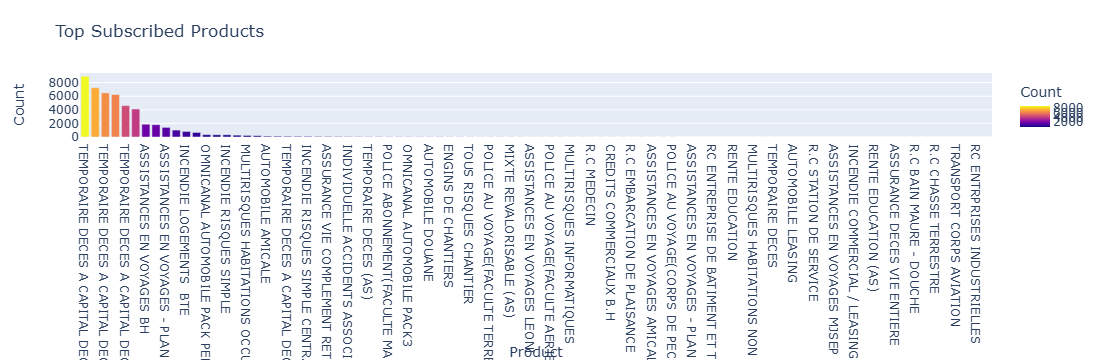

In [112]:
client_table['products_set'] = client_table['products_set'].apply(lambda x: x if isinstance(x, list) else [])
product_counts = client_table['products_set'].explode().value_counts().reset_index()
product_counts.columns = ['Product', 'Count']

fig = px.bar(product_counts, x='Product', y='Count', title='Top Subscribed Products', color='Count')
fig.show()

#### Average Contracts per Client Type

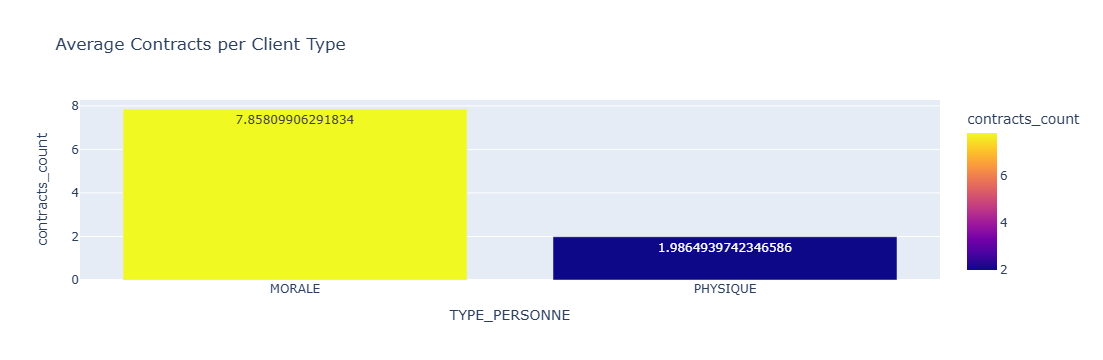

In [113]:
avg_contracts = client_table.groupby('TYPE_PERSONNE')['contracts_count'].mean().reset_index()

fig = px.bar(avg_contracts, x='TYPE_PERSONNE', y='contracts_count', 
             title='Average Contracts per Client Type', text='contracts_count', color='contracts_count')
fig.show()


#### Claims Frequency vs Sector / Profession

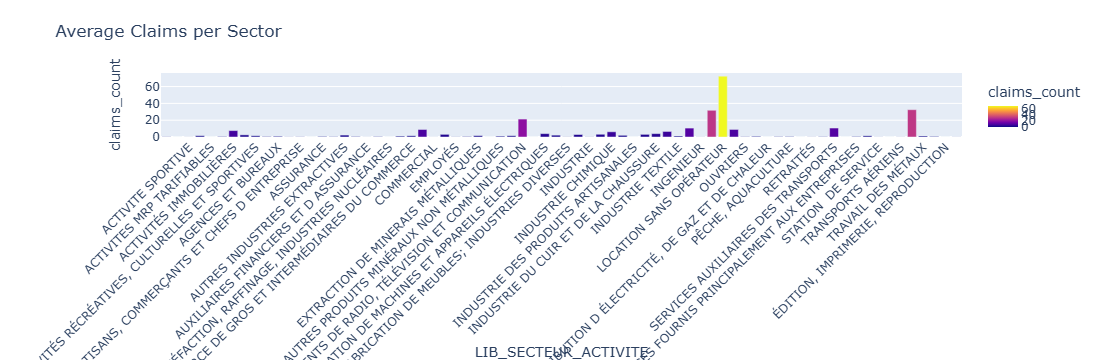

In [114]:
# Claims frequency by sector
sector_claims = client_table.groupby('LIB_SECTEUR_ACTIVITE')['claims_count'].mean().reset_index()
fig = px.bar(sector_claims, x='LIB_SECTEUR_ACTIVITE', y='claims_count', 
             title='Average Claims per Sector', color='claims_count')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

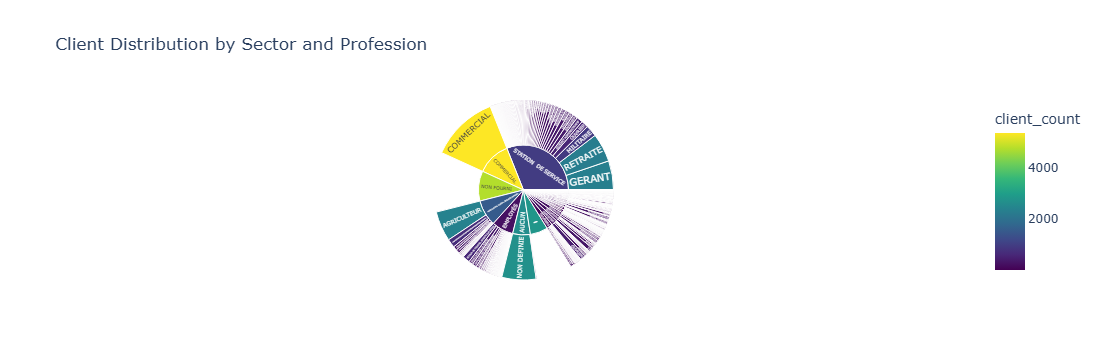

In [115]:
# Aggregate number of clients per sector and profession
prof_counts = client_table.groupby(
    ['LIB_SECTEUR_ACTIVITE', 'LIB_PROFESSION']
).size().reset_index(name='client_count')

# Sunburst plot
fig = px.sunburst(
    prof_counts,
    path=['LIB_SECTEUR_ACTIVITE', 'LIB_PROFESSION'],  # hierarchy
    values='client_count',                             # size of each slice
    color='client_count',                              # color by count
    color_continuous_scale='Viridis',
    title='Client Distribution by Sector and Profession'
)

fig.show()

#### Age Distribution vs Insurance Type

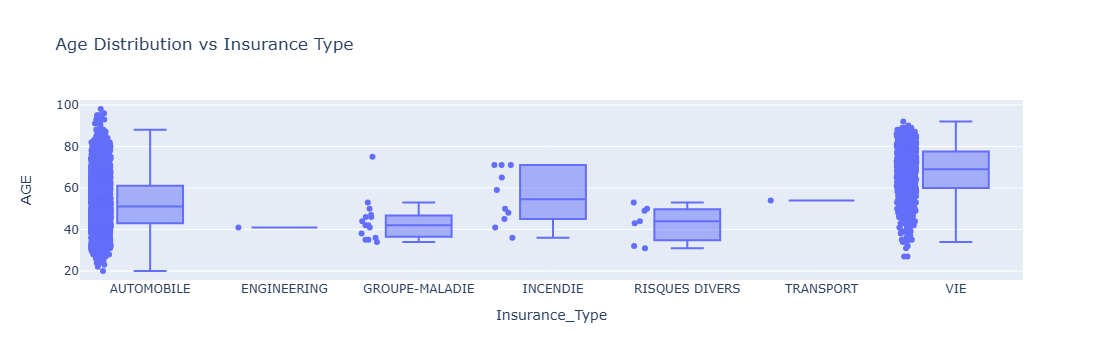

In [116]:
branch_columns = ['AUTOMOBILE', 'ENGINEERING', 'GROUPE-MALADIE', 
                  'INCENDIE', 'RISQUES DIVERS', 'TRANSPORT', 'VIE']

# Convert to long format for Plotly
age_claims = client_table.melt(
    id_vars=['REF_PERSONNE', 'AGE'],
    value_vars=branch_columns,
    var_name='Insurance_Type',
    value_name='Claims'
)

# Only include clients with at least one claim
age_claims = age_claims[age_claims['Claims'] > 0]

fig = px.box(age_claims, x='Insurance_Type', y='AGE', points='all', 
             title='Age Distribution vs Insurance Type')
fig.show()

In [117]:
client_table.describe()

AGE  contracts_count  active_contracts  expired_contracts  \
count  42373.000000     44061.000000      44061.000000       40343.000000   
mean      53.300286         2.086040          0.495858           1.404804   
std       15.474257         7.163322          1.107668           6.758019   
min        0.000000         0.000000          0.000000           0.000000   
25%       42.000000         1.000000          0.000000           0.000000   
50%       52.000000         1.000000          0.000000           1.000000   
75%       64.000000         2.000000          1.000000           2.000000   
max      115.000000       852.000000         25.000000         830.000000   

       reduced_contracts  instance_contracts  terminated_contracts  \
count       40343.000000        40343.000000          44061.000000   
mean            0.000050            0.000025              0.303647   
std             0.007041            0.004979              2.188664   
min             0.000000            0.000000              0.000000   
25%             0.000000            0.000000              0.000000   
50%             0.000000            0.000000              0.000000   
75%             0.000000            0.000000              0.000000   
max             1.000000            1.000000            429.000000   

       suspended_contracts  claims_count    AUTOMOBILE   ENGINEERING  \
count         44061.000000  44061.000000  44061.000000  44061.000000   
mean              0.000204      0.244910      0.204126      0.001294   
std               0.014291      3.892618      3.421482      0.112024   
min               0.000000      0.000000      0.000000      0.000000   
25%               0.000000      0.000000      0.000000      0.000000   
50%               0.000000      0.000000      0.000000      0.000000   
75%               0.000000      0.000000      0.000000      0.000000   
max               1.000000    552.000000    517.000000     17.000000   

       GROUPE-MALADIE      INCENDIE  RISQUES DIVERS     TRANSPORT  \
count    44061.000000  44061.000000    44061.000000  44061.000000   
mean         0.006219      0.008307        0.004176      0.004585   
std          0.399963      0.456729        0.348827      0.609932   
min          0.000000      0.000000        0.000000      0.000000   
25%          0.000000      0.000000        0.000000      0.000000   
50%          0.000000      0.000000        0.000000      0.000000   
75%          0.000000      0.000000        0.000000      0.000000   
max         60.000000     71.000000       50.000000    120.000000   

                VIE  has_recent_claim  
count  44061.000000      44061.000000  
mean       0.016205          0.014843  
std        0.142479          0.120926  
min        0.000000          0.000000  
25%        0.000000          0.000000  
50%        0.000000          0.000000  
75%        0.000000          0.000000  
max       13.000000          1.000000

In [118]:
client_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44061 entries, 0 to 44060
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   REF_PERSONNE          44061 non-null  object 
 1   RAISON_SOCIALE        44061 non-null  object 
 2   MATRICULE_FISCALE     44061 non-null  object 
 3   VILLE                 44061 non-null  object 
 4   LIB_GOUVERNORAT       44061 non-null  object 
 5   LIB_SECTEUR_ACTIVITE  44061 non-null  object 
 6   LIB_ACTIVITE          44061 non-null  object 
 7   VILLE_GOUVERNORAT     44061 non-null  object 
 8   TYPE_PERSONNE         44061 non-null  object 
 9   NOM_PRENOM            44061 non-null  object 
 10  DATE_NAISSANCE        44061 non-null  object 
 11  CODE_SEXE             44061 non-null  object 
 12  SITUATION_FAMILIALE   44061 non-null  object 
 13  NUM_PIECE_IDENTITE    44061 non-null  object 
 14  LIB_PROFESSION        44061 non-null  object 
 15  AGE                

#### 1. Preparing lists

In [119]:
# Ensure lists are proper Python lists (no NaNs)
client_table['branches_set'] = client_table['branches_set'].apply(lambda x: x if isinstance(x, list) else [])
client_table['products_set'] = client_table['products_set'].apply(lambda x: x if isinstance(x, list) else [])

#### 2. Handling missing numeric values 

In [120]:
numeric_cols = ['AGE', 'contracts_count', 'claims_count', 'has_recent_claim',
                'AUTOMOBILE','ENGINEERING','GROUPE-MALADIE','INCENDIE',
                'RISQUES DIVERS','TRANSPORT','VIE']
for col in numeric_cols:
    client_table[col] = client_table[col].fillna(0)


#### 3.Creating risk ratios

In [121]:
client_table['claims_ratio'] = client_table['claims_count'] / client_table['contracts_count']
client_table['recent_claim_ratio'] = client_table['has_recent_claim'] / client_table['contracts_count']

#### 4.categorizing clients by risk

In [122]:
client_table['risk_level'] = pd.cut(client_table['claims_count'],
                                   bins=[-1,0,2,5,10,100],
                                   labels=['None','Low','Medium','High','Very High'])

#### 5.Encoding multi-label target (products) 

In [123]:
from sklearn.preprocessing import MultiLabelBinarizer,OneHotEncoder, StandardScaler
mlb = MultiLabelBinarizer()
target_encoded = mlb.fit_transform(client_table['products_set'])
target_df = pd.DataFrame(target_encoded, columns=mlb.classes_, index=client_table.index)

#### 6. Selecting demographic & behavior features

In [124]:
demographics_cols = ['AGE', 'CODE_SEXE', 'LIB_SECTEUR_ACTIVITE', 'LIB_PROFESSION', 'LIB_GOUVERNORAT']
behavior_cols = ['contracts_count', 'claims_count', 'has_recent_claim',
                 'AUTOMOBILE','ENGINEERING','GROUPE-MALADIE','INCENDIE',
                 'RISQUES DIVERS','TRANSPORT','VIE','claims_ratio','recent_claim_ratio']

features = client_table[demographics_cols + behavior_cols]

#### 7. Encoding categorical features including risk_level

In [125]:
cat_cols = ['CODE_SEXE', 'LIB_SECTEUR_ACTIVITE', 'LIB_PROFESSION', 'LIB_GOUVERNORAT', 'risk_level']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = pd.DataFrame(ohe.fit_transform(client_table[cat_cols]),
                           columns=ohe.get_feature_names_out(cat_cols),
                           index=client_table.index)

#### 8. Normalize numeric features

In [126]:
num_cols = ['AGE', 'contracts_count', 'claims_count', 'has_recent_claim',
            'AUTOMOBILE','ENGINEERING','GROUPE-MALADIE','INCENDIE',
            'RISQUES DIVERS','TRANSPORT','VIE','claims_ratio','recent_claim_ratio']
scaler = StandardScaler()

# Making a copy to avoid SettingWithCopyWarning
features = features.copy()

# Normalizing numeric columns safely
features.loc[:, num_cols] = scaler.fit_transform(features[num_cols])


#### 9. Keeping REF_PERSONNE as identifier

In [127]:
features['REF_PERSONNE'] = client_table['REF_PERSONNE']

#### 10. Combine features and multi-label target

In [128]:
final_ml_dataset = pd.concat([features, target_df], axis=1)

#### 11. Saving ready-to-use dataset

In [129]:
final_ml_dataset.to_csv('../outputs/recommendation_dataset_risk_level_ml_ready.csv', index=False)

#### 12.Quick check

In [130]:
print(final_ml_dataset.head())
print("Shape:", final_ml_dataset.shape)

        AGE CODE_SEXE                               LIB_SECTEUR_ACTIVITE  \
0 -2.800787         -                                SERVICES PERSONNELS   
1 -2.800787         -  TRAVAIL DU BOIS ET FABRICATION D ARTICLES EN BOIS   
2 -2.800787         -                          INTERMÉDIATION FINANCIÈRE   
3 -2.800787         -                                       CONSTRUCTION   
4 -2.800787         -  TRAVAIL DU BOIS ET FABRICATION D ARTICLES EN BOIS   

  LIB_PROFESSION LIB_GOUVERNORAT  contracts_count  claims_count  \
0              -               -        -0.151613      0.193982   
1              -               -        -0.151613     -0.062917   
2              -               -         2.361216      1.478479   
3              -               -         6.270062      0.964680   
4              -               -         1.244403      0.450881   

   has_recent_claim  AUTOMOBILE  ENGINEERING  ...  \
0         -0.122746    0.232614    -0.011548  ...   
1         -0.122746   -0.059661   